In [106]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [16]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# 승객 ID 저장
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Feature Engineering

In [25]:
# 전체 데이터 보관
full_data = [train, test]

# 이름 길이
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# cabin 갖고 있는지 여부
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# 가족 구성원 수
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# FamilySize 1이면 IsAlone 피쳐 1
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1

# Embarked NaN값을 가장 많은 비율인 S로 채우기
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Fare NaN값을 Fare의 median으로 채우기    
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# qcut: 동일 갯수로 라벨 인코딩 (Fare 라벨 원소 수 동일)
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

"""
Age NaN 처리
나이의
[평균-표준편차 ~ 평균+표준편차] 범위의 랜덤 나이를 가져다가 NaN 에 채우기
"""
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)  # cut: 동일 길이로 라벨 인코딩 (연령별 길이 동일)

# 이름의 Mrs. Miss. 등 title 추출 함수
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

# title 추출
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# 희귀한 title 'Rare'로 치환
# Mlle, Ms, Mme -> Miss, Miss, Mrs 로 치환
for datast in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', "Miss")
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# categorical feature 'int형' 으로 바꾸기
for dataset in full_data:
    # 성별 여:0, 남:1 로 변환
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)
    
    # title int로 치환
    title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)  # NaN 는 0 으로.
    
    # Embarked int로 치환
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    
    # Fare 범위별로 끊어서 int로 치환
    dataset.loc[dataset['Fare']<=7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare']>7.91)&(dataset['Fare']<=14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare']>14.454)&(dataset['Fare']<=31), 'Fare'] = 2
    dataset.loc[dataset['Fare']>31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Age 범위별로 끊어서 int로 치환
    dataset.loc[dataset['Age']<=16, 'Age'] = 0
    dataset.loc[(dataset['Age']>16)&(dataset['Age']<=32), 'Age'] = 1
    dataset.loc[(dataset['Age']>32)&(dataset['Age']<=48), 'Age'] = 2
    dataset.loc[(dataset['Age']>48)&(dataset['Age']<=64), 'Age'] = 3
    dataset.loc[dataset['Age']>64, 'Age'] = 4


In [31]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

## Visualisation

In [32]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


- Pearson Correlation Heatmap

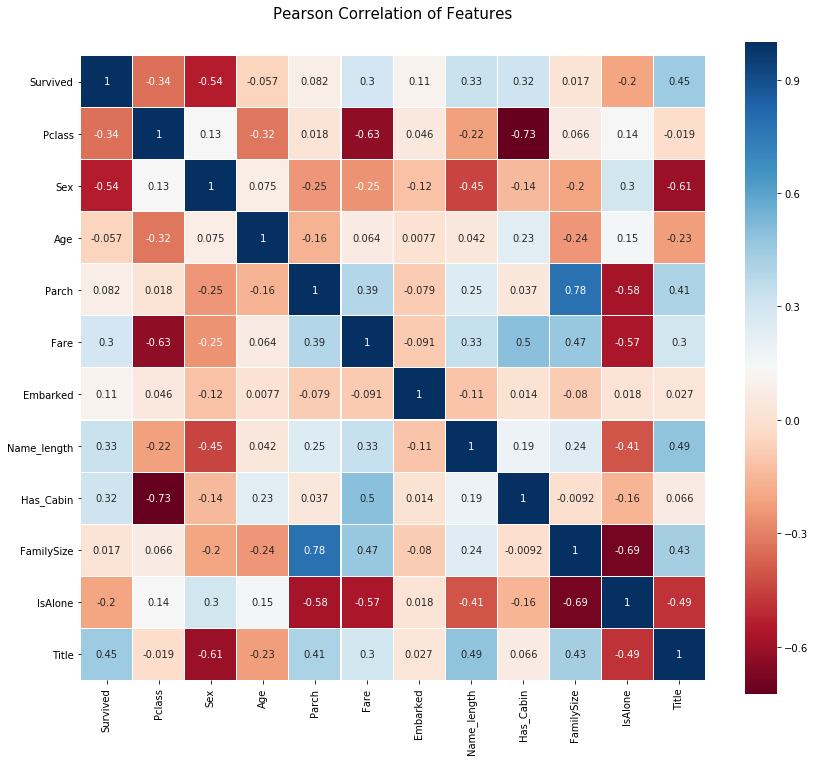

In [38]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

- Pairplots  
  
각 열의 조합에 따른 scatterplot 을 그려주고,  
행과 열이 같은 대각선 영역에선 히스토그램을 그려준다

<Figure size 1440x1440 with 0 Axes>

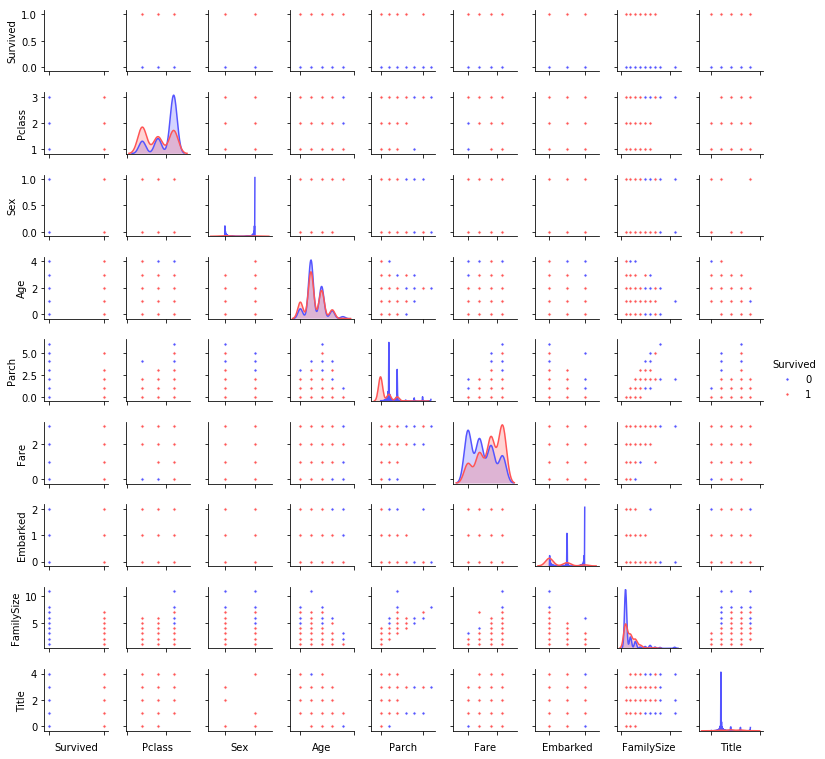

In [43]:
plt.figure(figsize=(20,20))
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title']],
                hue='Survived', palette='seismic', size=1.2, diag_kind='kde',
                diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

## Ensembling & Stacking models

In [103]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED)
# kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED) # error

# Sklearn classifier 를 넣어 사용하기 위한 Class
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)
        return self.clf.fit(x, y).feature_importances_

- Out-of-Fold Predictions (oof)

In [68]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models

In [71]:
# random forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
#     'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# extra trees parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
#     'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# adaboost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

# gradient boosting parameters
gb_params = {
    'n_estimators': 500,
#     'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# support vector classifier parameters
svc_params = {
    'kernel': 'linear',
    'C': 0.025
}

In [74]:
# sklearn model들로 5개 SklearnHelper 객체 생성
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [75]:
# train/test set numpy 배열로 만들기
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

- output of first level predictions

In [76]:
"""
OOF train/test prediction 만들기
이 결과들을 새 feature로 사용할 계획
"""

et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print('train is complete')

train is complete


In [101]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.13701393 0.19948866 0.02811545 0.02151425 0.07031331 0.02300378
 0.10544918 0.06514155 0.06808643 0.01338308 0.26849036]
[0.12843075 0.37434781 0.02577013 0.01591042 0.05462181 0.02748389
 0.04535956 0.08163143 0.04742506 0.01872931 0.18028985]
[0.028 0.032 0.018 0.068 0.042 0.01  0.698 0.004 0.048 0.002 0.05 ]
[0.1408379  0.02474293 0.04727666 0.01132846 0.0535151  0.02590597
 0.16462514 0.04623091 0.08342745 0.0051424  0.39696706]


In [100]:
rf_features = [0.13701393, 0.19948866, 0.02811545, 0.02151425, 0.07031331, 0.02300378,
 0.10544918, 0.06514155, 0.06808643, 0.01338308, 0.26849036]
et_features = [0.12843075, 0.37434781, 0.02577013, 0.01591042, 0.05462181, 0.02748389,
 0.04535956, 0.08163143, 0.04742506, 0.01872931, 0.18028985]
ada_features = [0.028, 0.032, 0.018, 0.068, 0.042, 0.01,  0.698, 0.004, 0.048, 0.002, 0.05 ]
gb_features = [0.1408379,  0.02474293, 0.04727666, 0.01132846, 0.0535151,  0.02590597,
 0.16462514, 0.04623091, 0.08342745, 0.0051424,  0.39696706]

In [111]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [112]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [117]:
# 4가지 모델들의 feature importances 평균
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.137014,0.128431,0.028,0.140838,0.108571
1,Sex,0.199489,0.374348,0.032,0.024743,0.157645
2,Age,0.028115,0.025770,0.018,0.047277,0.029791


In [118]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output

In [119]:
base_predictions_train = pd.DataFrame({'RandomForest':rf_oof_train.ravel(),
                                       'ExtraTrees': et_oof_train.ravel(),
                                       'AdaBoost': ada_oof_train.ravel(),
                                       'GradientBoost': gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [120]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [123]:
print(x_train.shape, x_test.shape)

(891, 11) (418, 11)


'uncorrelated' 모델들이 더 좋은 스코어를 낸다

In [124]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [127]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [128]:
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId,
                                   'Survived': predictions})
StackingSubmission.to_csv('StackingSubmission.csv', index=False)